# Correlate extreme regional SIC anomalies with modes of variabaility

### Author - Chris Wyburn-Powell, see the latest version on [github](https://github.com/chrisrwp/low-frequency-variability/blob/main/predict/Min_max_anomaly_groups.ipynb)

**Input:**
- `CMIP6_modeling_center_members_doi.nc`
- `CMIP6_members_CVDP_and_SIC.pickle`
- `Regional_SIC_HadISST1_1920_2022.nc`
- `Regional_SIC_detrended_lowpass_filter_<model_name>_<start_year>_2014.nc`
- `CVDP_standardized_linear_detrended_1920_2014_historical_<model_name>.nc`
- `CVDP_standardized_linear_detrended_1920_2014_CERA20C_ERAI_all_var.nc`
- `CVDP_standardized_linear_detrended_1920_2014_ERA20C_ERAI_all_var.nc`
- `CVDP_standardized_linear_detrended_1920_2014_HadISST_all_var.nc`

**Method:**
- Obtain the regional lowpass filtered SIC from obs and CMIP6 LEs for 1950-2014 (65 years)
- Find the years of the 6 largest and smallest anomalies in obs and CMIP6
- Get seasonal CVDP for obs and CMIP6 at 3, 5, 10, 15 year lead times to the largest SIC anomalies
- Calculate the +ve and -ve correlations with each climate mode for each member or obs
- Sum up the +ve and -ve correlations in 4 part bar chart for the 4 lead times

**Output:**
- `binary_correlations_1956_2014_months_9_lag_4_15_best_LE_seasons_lowpass_filt.nc`
- Figure 7
<br>

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy.signal as signal
import glob 
import pickle
import datetime
import matplotlib.pyplot as plt

In [2]:
CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_members_CVDP_and_SIC.pickle', 'rb') as handle:
    CMIP6_mem = pickle.load(handle)

#open time dataset for standardizing all times to
time_xr = xr.open_dataarray(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    'datetime64_1850_2100_monthly.nc')

GCM_LE_20 = ['ACCESS-ESM1-5', 'CESM2-LENS', 'CNRM-CM6-1', 'CanESM5',
       'EC-Earth3', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR', 'NorCPM1',]

## Obtain the lowpass regional SIC from models and observations

In [6]:
# open the SIC data from HadISST1 and save >30N and specificed time period
HadISST1 = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    +'HadISST_ice_2023_03.nc')

HadISST1_30N = HadISST1['sic'].sel(time=slice('1920','2022')).where(
    HadISST1['latitude']>30, drop=True) 

#adjust to mid-month to exactly match models
HadISST1_30N['time'] = time_xr.sel(time=slice('1920-01','2022-12')) 

#fill the spurious data with the most appropriate nearby year's data
HadISST1_2009_03 = HadISST1_30N.sel(time='2007-03').copy()
HadISST1_2009_03['time'] = xr.DataArray(
    data = time_xr.sel(time='2009-03').values, 
    coords={'time': time_xr.sel(time='2009-03').values}, 
    dims=['time'],
)

HadISST1_2009_04 = HadISST1_30N.sel(time='2008-04').copy()
HadISST1_2009_04['time'] = xr.DataArray(
    data = time_xr.sel(time='2009-04').values, 
    coords={'time': time_xr.sel(time='2009-04').values}, 
    dims=['time'],
)

HadISST1_30N_correct = xr.concat(
    (HadISST1_30N.sel(time=slice('1920-01','2009-02')), 
    HadISST1_2009_03, HadISST1_2009_04, 
    HadISST1_30N.sel(time=slice('2009-05','2022-12'))), 
    dim='time'
)

HadISST1_30N_correct_xr = xr.Dataset({'SIC':HadISST1_30N_correct})
HadISST1_30N_correct_xr.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    +'HadISST1_30N_filled_1920-2022.nc')

# HadISST1_30N_correct_xr = xr.open_dataset(
#     '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
#     +'HadISST1_30N_filled_1920-2022.nc')

In [7]:
#calculate the regional SIC time series

#load the areacello and region mask files
areacello = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    +'HadISST1_gridarea.nc')
areacello_with_nan = areacello['cell_area']

region_mask = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/masie_masks/'\
    +'masiemask_HadISST1.nc')

In [8]:
SIC = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    +'HadISST1_30N_filled_1920-2022.nc')
    
SIC = SIC['SIC'].where(areacello_with_nan, drop=False).sel(
    time=slice('1920','2022'))

#only do the calculation where there is sea ice
SIC = SIC.where(SIC>0)

#calculate the pan-Arctic SIA and SIV
pan_Arctic_SIA = (SIC * areacello_with_nan).sum('latitude').sum('longitude')

SIA_regions = []
SIC_regions_av = []
for region_ in np.arange(1,17):
    area_region = areacello_with_nan.where(
        region_mask['regions']==region_).sum()

    SIC_region = SIC.where((region_mask['regions']==region_))
    SIA_region = (SIC_region * areacello_with_nan).sum('latitude').sum(
        'longitude')

    SIA_regions.append(SIA_region)
    SIC_regions_av.append(SIA_region / area_region)


######################### concatenate all regions ##########################
SIA_regions =  xr.concat((SIA_regions),dim='region')
SIA_regions['region'] = np.arange(1,17)
SIC_regions_av = xr.concat((SIC_regions_av),dim='region')
SIC_regions_av['region'] = np.arange(1,17)

final_dataset = xr.Dataset(
        {'regional_SIA':SIA_regions, 'regional_SIC':SIC_regions_av,
         'Arctic_SIA':pan_Arctic_SIA, 
        }
    )

In [9]:
final_dataset.attrs = {
    'Description' : 'Regional average sea ice concentration (SIC), area (SIA) '\
        'and pan-Arctic SIA in % for the observational dataset HadISST1 '\
        'for each month for from 1920 to 2022. Regions as defined '\
        'for NSIDC MASIE-NH Version 1, doi:10.7265/N5GT5K3K.',
    'Timestamp' : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
    'Data source' :  'https://www.metoffice.gov.uk/hadobs/hadisst/data/'\
        +'download.html accessed on 2023-03-09. doi:10.1029/2002JD002670',
    'Analysis' : 'https://github.com/chrisrwp/low-fequency-variability/'\
        +'blob/main/predict/Min_max_anomaly_groups.ipynb'
}

(final_dataset*100).to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'Regional_SIC_HadISST1_1920_2022.nc')

## Detrend, standardize to 1 SIC in winter regions, lowpass filter

In [24]:
def filt_lowpass(data_, sample_freq, cutoff, order, ax_n, detrend=False,
                 standard=False):
    '''
    Filter a time series using a lowpass Butterworth filter. 
    Uses scipy.signal.butter and scipy.signal.filtfilt
    
    Parameters
    ----------
    data_ : n dimensional xarray dataarray,
        Data to detrend and/or standardize, which can contain nans
    sample_freq: float,
        The sampling frequency of the input data, typically sample_freq=1 [year]
    cutoff: float,
        The fraction of the nyquist frequency (itself half the sampling 
        frequency). To filter with a 2-year lowpass filter with
        sample_freq=1 (year), cutoff=0.25
    order: int
        The order of the Butterworth filter, typically 4-6
    ax_n : int
        Which axis to do the filtering on (time)
    detrend: bool
        Whether to detrend the data with a linear trend
    standard: bool
        Whether to standardize the data after filtering

    Returns
    ----------
        numpy array of the same shape as the input data
    '''

    if detrend: #detrend the data first
        data_ = (data_ * 0) + signal.detrend(data=data_.fillna(0), axis=ax_n)

    b, a = signal.butter(order, cutoff, btype='lowpass') #low pass filter
    #apply the filter forward and backward along a given axis
    filtered = signal.filtfilt(b, a, data_, axis=ax_n) 

    filtered_xr = (data_ * 0) + filtered

    if standard: #standardize the data
        filtered_xr = (filtered_xr - filtered_xr.mean('time')) \
                      / filtered_xr.std('time')

    return(filtered_xr)

In [25]:
unfiltered = final_dataset['regional_SIC'].copy()

mem_data_adj = (unfiltered.sel(region=[1,2,3,4,5,11])
                / unfiltered.sel(region=[1,2,3,4,5,11]).max('time'))

unfiltered_cor = xr.concat((unfiltered.drop_sel(
    region=[1,2,3,4,5,11]),mem_data_adj), dim='region').sortby('region')   

In [35]:
all_month_filtered = []
for month_ in np.arange(1,13):
    
    all_regions_filtered = []
    for region_ in np.arange(1,17):
        #calculate the linear trend for 1920-2014 for each month
        month_raw = unfiltered_cor.sel(
            time=unfiltered_cor['time.month']==month_).sel(
            time=slice('1920','2014')).sel(region=region_)

        coefs = np.polyfit(np.arange(1920,2015), month_raw, deg=1)
        
        #remove the linear trend for 1920-2014 for all data 1920-2022
        lin_detrend = (unfiltered_cor.sel(region=region_).sel(
            time=unfiltered_cor['time.month']==month_)
            - (np.arange(1920,2023)*coefs[0] + coefs[1])
        )
        
        #now apply a lowpass filter with a 2-year cutoff
        b, a = signal.butter(N=5, Wn=0.25, btype='lowpass')

        filtered = signal.filtfilt(b, a, lin_detrend, axis=0) 
        filtered_xr = (lin_detrend * 0) + filtered
        filtered_xr['time'] = np.arange(1920,2023)
    
        all_regions_filtered.append(filtered_xr)
    
    filt_month = xr.concat((all_regions_filtered),dim='region')
    filt_month = filt_month.rename({'time':'year'})
    all_month_filtered.append(filt_month)
    
all_month_data = xr.concat((all_month_filtered), dim='month')
all_month_data['month'] = np.arange(1,13)

In [49]:
all_month_data.attrs = {
    'Description' : '2 year lowpass filter of linearly detrended regional '\
        +'average sea ice concentration (SIC) in % for the observational '\
        +'dataset HadISST1 for each month for 1920-2022 with linear trend '\
        +'calculated for 1920-2014. Regions as defined '\
        +'for NSIDC MASIE-NH Version 1, doi:10.7265/N5GT5K3K.',
    'Timestamp' : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
    'Data source' :  'https://www.metoffice.gov.uk/hadobs/hadisst/data/'\
        +'download.html accessed on 2023-03-09. doi:10.1029/2002JD002670',
    'Analysis' : 'https://github.com/chrisrwp/low-fequency-variability/'\
        +'blob/main/predict/Min_max_anomaly_groups.ipynb'
}

(all_month_data*100).to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'Regional_SIC_detrended_lowpass_filter_HadISST1_1920_2022.nc')

## Find the 6 highest and lowest SIC anomalies by region

In [3]:
#load obs regional lowpass filtered SIC data
# HadISST1_lowpass = xr.open_dataset(
#     '/glade/work/cwpowell/low-frequency-variability/input_data/'\
#     +'Regional_SIC_detrended_lowpass_filter_HadISST1_1950_2014.nc')
# HadISST1_lowpass = xr.open_dataset(
#     '/glade/work/cwpowell/low-frequency-variability/input_data/'\
#     +'Regional_SIC_bandpass_2_40_year_HadISST1_1960_2022.nc')
HadISST1_lowpass = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'Regional_SIC_detrended_lowpass_filter_HadISST1_1920_2022.nc')

#load CMIP6 lowpass filtered SIC data
all_SIC_lowpass = {}
for GCM in GCM_LE_20:
    SIC_data = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/input_data/'\
        +f'Regional_SIC_detrended_lowpass_filter_{GCM}_1920_2014.nc'
    )
    # SIC_data = xr.open_dataset(
    #     '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    #     +f'Regional_SIC_bandpass_2_40_year_{GCM}_1920_2014.nc'
    # )
    
    
    #select the years for this analysis period and sort by member
    all_SIC_lowpass[GCM] = SIC_data['SIC'].sortby('member').sel(
        year=slice('1956','2014'))
    

In [22]:
# HadISST1_60_14 = []
# for month_ in np.arange(1,13):
#     data = HadISST1_lowpass['SIC'].sel(time=HadISST1_lowpass['time.month']==month_)
#     data = data.rename({'time':'year'})
#     if month_ == 12:
#         data['year'] = np.arange(1960,2022)
#     else:
#         data['year'] = np.arange(1960,2023)
#     HadISST1_60_14.append(data.sel(year=slice('1960','2014')))
    
# HadISST1_60_14 = xr.concat((HadISST1_60_14),dim='month')
# HadISST1_60_14['month'] = np.arange(1,13)

# low_years_LE = {}
# high_years_LE = {}
# for GCM in GCM_LE_20:
#     low_years_LE[GCM] = all_SIC_lowpass[GCM]['year'].where(
#         all_SIC_lowpass[GCM].rank('year')<6)
#     high_years_LE[GCM] = all_SIC_lowpass[GCM]['year'].where(
#         all_SIC_lowpass[GCM].rank('year')>50)
    
# low_years_obs = HadISST1_60_14['year'].where(HadISST1_60_14.rank('year')<6)
# high_years_obs = HadISST1_60_14['year'].where(HadISST1_60_14.rank('year')>50)

In [4]:
HadISST1_56_14 = []
for month_ in np.arange(1,13):
    data = HadISST1_lowpass['regional_SIC'].sel(month=month_)
    data['year'] = np.arange(1920,2023)
    HadISST1_56_14.append(data.sel(year=slice('1956','2014')))
    
HadISST1_56_14 = xr.concat((HadISST1_56_14),dim='month')
HadISST1_56_14['month'] = np.arange(1,13)

low_years_LE = {}
high_years_LE = {}
for GCM in GCM_LE_20:
    low_years_LE[GCM] = all_SIC_lowpass[GCM]['year'].where(
        all_SIC_lowpass[GCM].rank('year')<7)
    high_years_LE[GCM] = all_SIC_lowpass[GCM]['year'].where(
        all_SIC_lowpass[GCM].rank('year')>53)
    
low_years_obs = HadISST1_56_14['year'].where(HadISST1_56_14.rank('year')<7)
high_years_obs = HadISST1_56_14['year'].where(HadISST1_56_14.rank('year')>53)

## Compute whether there are positive or negative modes for each SIC anomaly

In [7]:
#generate a list of variable and season names
CVDP_sample = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/'\
    +'input_data/CVDP_standardized_linear_detrended_1920_'\
    +'2014_historical_CanESM5.nc')

var_month_list = []
for i in CVDP_sample.to_array()['variable'].values:
    for month_num in [1,4,7,10]:
        var_month_list.append(str(i)+'_'+str(month_num))

In [5]:
#load the CVDP data in models
def load_CVDP(model_name, month_, lag_, target_year, target_month, mem_):
    '''
    Load the training, validation and testing data of the climate modes of
    varaibility (features), corresponding to the time period of the sea ice
    data (target) and the lag time. Additionally, remove certain climate modes
    and/or include a white noise variable.
    
    Parameters
    ----------
    model_name: str,
        The name of the GCM which provides a sufficiently large ensemble.
    month_: int,
        The month of the target sea ice concentration, this will determine
        how many years lagged each season is, e.g. if sea ice concentration
        is for October the seasonal CVDP data will be lagged 2 years for DJF,
        MAM and JJA, but 3 years for SON.
    lag_: int,
        The number of years the CVDP data is offset before the sea ice data 
    target_year: integer,
        The year of the target SIC data, CVDP output data will be lagged 
        relative to this year and the month of target_month
    target_month: integer
        The month of the taget SIC data
    mem_ : string
        The variant ID of the chosen member
    
    Returns
    ----------
    CVDP_all: Xarray Dataset,
        The stacked CVDP data for all members
    ''' 
    
    #load CVDP features and convert to seasonal data
    #select the NetCDF file with lowpass filtering or linear detrending
    CVDP_year_month = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/input_data/'\
        +'CVDP_standardized_linear_detrended_1920_2014_historical_'\
        +f'{model_name}.nc'
    )    

    CVDP_year_month = CVDP_year_month.to_array('variable').sortby('time')

    month_seperate = []
    for i in [1,4,7,10]:
        temp_data = CVDP_year_month.sel(
            time=CVDP_year_month['time.month']==i)
        temp_data['time'] = np.arange(1920,2015)
        month_seperate.append(temp_data)

    CVDP_data = xr.concat((month_seperate), dim='month')
    CVDP_data['month'] = [1,4,7,10]
    CVDP_data = CVDP_data.rename({'time':'year'})

    #now stack the CVDP data into X members and years, Y features
    CVDP_all = []
    for lag_season in [1,4,7,10]: 
        if lag_season >= target_month:
            extra_year = 1
        else:
            extra_year = 0

        CVDP_month_data = CVDP_data.sortby('member')
            
        CVDP_month_data = CVDP_month_data.sel(
            month=lag_season).sel(
            year=(target_year-lag_-extra_year))
        
        CVDP_all.append(CVDP_month_data)
        
    #now just return the first year of the CVDP data
    CVDP_all = xr.concat((CVDP_all),dim='month')
    CVDP_all = CVDP_all.stack(var_month=('variable','month'))
    CVDP_all['var_month'] = var_month_list
    CVDP_all = CVDP_all.sel(var_month=[
        'AMO_1', 'IPO_4', 'NINO34_1', 'PDO_4', 'ATN_4', 'NPO_4', 'PNA_4',
        'NAO_1', 'TAS_7'])
    CVDP_all = CVDP_all.drop('year')
    CVDP_all = CVDP_all.sel(member=mem_)
    
    return(CVDP_all)

In [ ]:
lag_list = np.arange(4,16)
month_list = [9]

for GCM in GCM_LE_20:
    print(datetime.datetime.now(), GCM)
    
    if len(glob.glob(
        f'/glade/work/cwpowell/low-frequency-variability/predictions/{GCM}_binary_'\
        'correlations_1956_2014_months_9_lag_4_15_best_LE_seasons_lowpass_filt.nc'))>0:
        continue
    
    all_month_CVDP_high = []
    all_month_CVDP_low = []
    for month_ in month_list:
        
        all_region_CVDP_high = []
        all_region_CVDP_low = []
        for region_ in [1,2,3,4,5,6,11]:
            print(datetime.datetime.now(), 'region', region_)
            
            all_lag_CVDP_high = []
            all_lag_CVDP_low = []
            for lag_ in lag_list:
                print(lag_, end=',')
                
                low_yr_data = low_years_LE[GCM].sel(month=month_).sel(
                    region=region_)
                high_yr_data = high_years_LE[GCM].sel(month=month_).sel(
                    region=region_)    
                
                all_mem_CVDP_high = []
                all_mem_CVDP_low = []
                for mem in low_yr_data['member']:
                    
                    all_anom_CVDP_high = []
                    all_anom_CVDP_low = []
                    for anom_i in range(6):
                        
                        anom_year = np.sort(high_yr_data.sel(member=mem))[anom_i]
                        CVDP_lead_high = load_CVDP(
                            GCM, month_, lag_, anom_year, month_, mem)
                        CVDP_lead_high = CVDP_lead_high.where(CVDP_lead_high>0,-1)
                        all_anom_CVDP_high.append(
                            CVDP_lead_high.where(CVDP_lead_high==-1,1))
                        
                        anom_year = np.sort(low_yr_data.sel(member=mem))[anom_i]
                        CVDP_lead_low = load_CVDP(
                            GCM, month_, lag_, anom_year, month_, mem)
                        CVDP_lead_low = CVDP_lead_low.where(CVDP_lead_low>0,-1)
                        all_anom_CVDP_low.append(
                            CVDP_lead_low.where(CVDP_lead_low==-1,1))
                        
                    all_mem_CVDP_high.append(xr.concat((all_anom_CVDP_high),
                                             dim='anom_i').sum('anom_i'))
                    all_mem_CVDP_low.append(xr.concat((all_anom_CVDP_low),
                                             dim='anom_i').sum('anom_i'))
                    
                all_lag_CVDP_high.append(xr.concat((all_mem_CVDP_high),
                                                   dim='member'))
                all_lag_CVDP_low.append(xr.concat((all_mem_CVDP_low),
                                                  dim='member'))
                    
            all_region_CVDP_high.append(xr.concat((all_lag_CVDP_high),
                                                  dim='lag'))
            all_region_CVDP_low.append(xr.concat((all_lag_CVDP_low),
                                                 dim='lag'))
                    
        all_month_CVDP_high.append(xr.concat((all_region_CVDP_high),
                                             dim='region'))
        all_month_CVDP_low.append(xr.concat((all_region_CVDP_low),
                                            dim='region'))
        
    all_CVDP_high = xr.concat((all_month_CVDP_high), dim='month')
    all_CVDP_high['lag'] = lag_list
    all_CVDP_low = xr.concat((all_month_CVDP_low), dim='month')
    all_CVDP_low['lag'] = lag_list
    
    high_low_xr = xr.Dataset({'high_SIC_anom':all_CVDP_high, 
                              'low_SIC_anom':all_CVDP_low})
    
    high_low_xr.to_netcdf(
        f'/glade/work/cwpowell/low-frequency-variability/predictions/{GCM}_'\
        'binary_correlations_1956_2014_months_9_lag_4_15_best_LE_seasons_lowpass_filt.nc'
    )

2023-11-02 15:19:28.416481 ACCESS-ESM1-5
2023-11-02 15:19:28.416772 CESM2-LENS
2023-11-02 15:19:28.416907 CNRM-CM6-1
2023-11-02 15:19:28.417033 CanESM5
2023-11-02 15:19:28.417158 EC-Earth3
2023-11-02 15:19:28.417283 GISS-E2-1-G
2023-11-02 15:19:28.417408 GISS-E2-1-H
2023-11-02 15:19:28.417560 IPSL-CM6A-LR
2023-11-02 15:19:28.417682 MIROC-ES2L
2023-11-02 15:19:28.417806 MIROC6
2023-11-02 15:19:28.417928 MPI-ESM1-2-LR
2023-11-02 15:19:28.418089 region 1
4,5,6,7,8,9,10,11,12,13,14,15,2023-11-02 15:22:08.344462 region 2
4,5,6,7,8,9,10,11,12,13,14,15,2023-11-02 15:24:54.677619 region 3
4,5,6,7,8,9,10,11,7,8,9,10,11,12,13,14,15,2023-11-02 15:30:23.960248 region 5
4,5,6,7,8,9,10,11,12,13,14,15,2023-11-02 15:33:05.631061 region 6
4,5,6,7,8,9,10,11,12,13,14,15,2023-11-02 15:35:47.430649 region 11
4,5,6,7,8,9,10,11,12,13,14,15,2023-11-02 15:38:29.136561 NorCPM1
2023-11-02 15:38:29.137021 region 1
4,5,6,7,8,9,10,11,

In [10]:
high_low_xr = xr.open_dataset(
        f'/glade/work/cwpowell/low-frequency-variability/predictions/{GCM}_'\
        'binary_correlations_1956_2014_months_9_lag_4_15_best_LE_seasons_lowpass_filt.nc'
    )

### Now run the calculations for the observational data

In [9]:
#load the CVDP obs data from HadISST1
CERA20C_ERAI = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'CVDP_standardized_linear_detrended_1920_2014_CERA20C_ERAI_all_var.nc')
ERA20C_ERAI  = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'CVDP_standardized_linear_detrended_1920_2014_ERA20C_ERAI_all_var.nc')
HadISST_CVDP = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'CVDP_standardized_linear_detrended_1920_2014_HadISST_all_var.nc')

#if variable is in the following list use the HadISST data, otherwise use 
HadISST_vars = ['AMO', 'AMM', 'ATN', 'IOD', 'IPO', 'NINO34', 'PDO', 'TAS']
ERA20C_ERAI_vars = ['NAM','NAO','NPI','NPO','PNA','SAM']

CVDP_year_month_obs = xr.concat(
    (HadISST_CVDP.to_array().sel(variable=HadISST_vars),
     ERA20C_ERAI.to_array().sel(variable=ERA20C_ERAI_vars)),dim='variable')

In [13]:
var_month_list_obs = []
for i in CVDP_year_month_obs['variable'].values:
    for month_num in [1,4,7,10]:
        var_month_list_obs.append(str(i)+'_'+str(month_num))

In [14]:
def load_CVDP_obs(lag_, target_year, target_month):
    #load CVDP features and convert to seasonal data
    
    month_seperate = []
    for i in [1,4,7,10]:
        temp_data = CVDP_year_month_obs.sel(
            time=CVDP_year_month_obs['time.month']==i)
        temp_data['time'] = np.arange(1920,2015)
        month_seperate.append(temp_data)

    CVDP_data = xr.concat((month_seperate), dim='month')
    CVDP_data['month'] = [1,4,7,10]
    CVDP_data = CVDP_data.rename({'time':'year'})

    #now stack the CVDP data into X members and years, Y features
    CVDP_all = []
    for lag_season in [1,4,7,10]: 
        if lag_season >= target_month:
            extra_year = 1
        else:
            extra_year = 0
            
        CVDP_month_data = CVDP_data.sel(
            month=lag_season).sel(
            year=(target_year-lag_-extra_year))
        
        CVDP_all.append(CVDP_month_data)
        
    #now just return the first year of the CVDP data
    CVDP_all = xr.concat((CVDP_all),dim='month')
    CVDP_all = CVDP_all.stack(var_month=('variable','month'))
    CVDP_all['var_month'] = var_month_list_obs
    CVDP_all = CVDP_all.sel(var_month=[
        'AMO_1', 'IPO_4', 'NINO34_1', 'PDO_4', 'ATN_4', 'NPO_4', 'PNA_4',
        'NAO_1', 'TAS_7'])
    CVDP_all = CVDP_all.drop('year')
    
    return(CVDP_all)

In [15]:
all_month_CVDP_high = []
all_month_CVDP_low = []
for month_ in [8,9,10]:
    print(datetime.datetime.now(), 'month', month_)
        
    all_region_CVDP_high = []
    all_region_CVDP_low = []
    for region_ in [1,2,3,4,5,6,11]:
            
        all_lag_CVDP_high = []
        all_lag_CVDP_low = []
        for lag_ in np.arange(1,21):

            low_yr_data = np.sort(low_years_obs.sel(month=month_).sel(region=region_))
            high_yr_data = np.sort(high_years_obs.sel(month=month_).sel(region=region_))
                    
            all_anom_CVDP_high = []
            all_anom_CVDP_low = []
            for anom_i in range(6):

                anom_year = high_yr_data[anom_i]
                
                CVDP_lead_high = load_CVDP_obs(lag_, anom_year, month_)
                CVDP_lead_high = CVDP_lead_high.where(CVDP_lead_high>0,-1)
                all_anom_CVDP_high.append(
                    CVDP_lead_high.where(CVDP_lead_high==-1,1))

                anom_year = low_yr_data[anom_i]
                CVDP_lead_low = load_CVDP_obs(lag_, anom_year, month_)
                CVDP_lead_low = CVDP_lead_low.where(CVDP_lead_low>0,-1)
                all_anom_CVDP_low.append(
                    CVDP_lead_low.where(CVDP_lead_low==-1,1))

            all_lag_CVDP_high.append(xr.concat((all_anom_CVDP_high),
                                     dim='anom_i').sum('anom_i'))
            all_lag_CVDP_low.append(xr.concat((all_anom_CVDP_low),
                                     dim='anom_i').sum('anom_i'))

        all_region_CVDP_high.append(xr.concat((all_lag_CVDP_high),dim='lag'))
        all_region_CVDP_low.append(xr.concat((all_lag_CVDP_low),dim='lag'))

    all_month_CVDP_high.append(xr.concat((all_region_CVDP_high),dim='region'))
    all_month_CVDP_low.append(xr.concat((all_region_CVDP_low),dim='region'))

all_CVDP_high = xr.concat((all_month_CVDP_high), dim='month')
all_CVDP_high['lag'] = np.arange(1,21)
all_CVDP_high['region'] = [1,2,3,4,5,6,11]
all_CVDP_high['month'] = [8,9,10]

all_CVDP_low = xr.concat((all_month_CVDP_low), dim='month')
all_CVDP_low['lag'] = np.arange(1,21)
all_CVDP_low['region'] = [1,2,3,4,5,6,11]
all_CVDP_low['month'] = [8,9,10]

high_low_xr = xr.Dataset({'high_SIC_anom':all_CVDP_high, 
                          'low_SIC_anom':all_CVDP_low})

high_low_xr.to_netcdf(
        '/glade/work/cwpowell/low-frequency-variability/predictions/'\
        f'HadISST1_binary_correlations_1956_2014_months_8_9_10_lag_1_20_'\
        'best_LE_seasons.nc'
    )

2023-11-03 08:41:29.538546 month 8
2023-11-03 08:41:56.084615 month 9
2023-11-03 08:42:21.996474 month 10


In [17]:
all_high_SIC = {}
all_low_SIC = {}
for var_ in CVDP_vars:
    print(datetime.datetime.now(), var_)
    if var_ in HadISST_vars:
        CVDP_use = HadISST_CVDP[var_].copy()
    else:
        CVDP_use = CERA20C_ERAI[var_].copy()
        
    high_months = []
    low_months = []
    for month_ in np.arange(1,13):
        
        high_regions = []
        low_regions = []
        for region_ in [1,2,3,4,5,6,11]:
            
            #NEED TO CONVERT TIME TO MONTH AND YEAR!!!!!!
            CVDP_data = CVDP_use.sel(time=CVDP_use['time.month']==month_).sel(
                time=slice('1950','2015'))
            CVDP_data['time'] = np.arange(1950,2015)
            CVDP_data = CVDP_data.rename({'time':'year'})
            
            highest_yrs = highest_years['year'].where(
                highest_years.sel(month=month_).sel(region=region_)>0,drop=True)
            lowest_yrs = lowest_years['year'].where(
                lowest_years.sel(month=month_).sel(region=region_)>0,drop=True)
            
            #append the region data
            high_regions.append(CVDP_data.sel(year=highest_yrs))
            low_regions.append(CVDP_data.sel(year=lowest_yrs))
        
        #concatenate the region data and append to the monthly data
        high_months.append(xr.concat((high_regions),dim='region'))
        low_months.append(xr.concat((low_regions),dim='region'))
    
    high_months_xr = xr.concat((high_months), dim='month')
    high_months_xr['month'] = np.arange(1,13)
    high_months_xr['region'] = [1,2,3,4,5,6,11]
    all_high_SIC[var_] = high_months_xr

    low_months_xr = xr.concat((low_months), dim='month')
    low_months_xr['month'] = np.arange(1,13)
    low_months_xr['region'] = [1,2,3,4,5,6,11]
    all_low_SIC[var_] = low_months_xr

2023-02-20 10:49:14.779608 AMO
2023-02-20 10:49:15.602470 IPO
2023-02-20 10:49:16.403689 NINO34
2023-02-20 10:49:17.205960 PDO
2023-02-20 10:49:18.019267 AMM
2023-02-20 10:49:18.819680 ATN
2023-02-20 10:49:19.628027 IOD
2023-02-20 10:49:20.447629 NPI
2023-02-20 10:49:21.353347 NAM
2023-02-20 10:49:22.270838 NPO
2023-02-20 10:49:23.175233 PNA
2023-02-20 10:49:24.078132 NAO
2023-02-20 10:49:24.976944 SAM
2023-02-20 10:49:25.894431 TAS


In [ ]:
#now calculate postive or negative anomalies for all GCM members

for GCM in ['CanESM5', 'CESM2-LENS', 'MIROC6', 'GISS-E2-1-G', 'ACCESS-ESM1-5',
 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorCPM1', 'GISS-E2-1-H',
 'EC-Earth3', 'CNRM-CM6-1', 'UKESM1-0-LL']:
    
    
    
    lowest_years = HadISST1_50_14['year'].where(HadISST1_50_14.rank('year')<7)
    highest_years = HadISST1_50_14['year'].where(HadISST1_50_14.rank('year')>59)

all_high_SIC = {}
all_low_SIC = {}
for var_ in CVDP_vars:
    print(datetime.datetime.now(), var_)
    if var_ in HadISST_vars:
        CVDP_use = HadISST_CVDP[var_].copy()
    else:
        CVDP_use = CERA20C_ERAI[var_].copy()
        
    high_months = []
    low_months = []
    for month_ in np.arange(1,13):
        
        high_regions = []
        low_regions = []
        for region_ in [1,2,3,4,5,6,11]:
            
            #NEED TO CONVERT TIME TO MONTH AND YEAR!!!!!!
            CVDP_data = CVDP_use.sel(time=CVDP_use['time.month']==month_).sel(
                time=slice('1950','2015'))
            CVDP_data['time'] = np.arange(1950,2015)
            CVDP_data = CVDP_data.rename({'time':'year'})
            
            highest_yrs = highest_years['year'].where(
                highest_years.sel(month=month_).sel(region=region_)>0,drop=True)
            lowest_yrs = lowest_years['year'].where(
                lowest_years.sel(month=month_).sel(region=region_)>0,drop=True)
            
            #append the region data
            high_regions.append(CVDP_data.sel(year=highest_yrs))
            low_regions.append(CVDP_data.sel(year=lowest_yrs))
        
        #concatenate the region data and append to the monthly data
        high_months.append(xr.concat((high_regions),dim='region'))
        low_months.append(xr.concat((low_regions),dim='region'))
    
    high_months_xr = xr.concat((high_months), dim='month')
    high_months_xr['month'] = np.arange(1,13)
    high_months_xr['region'] = [1,2,3,4,5,6,11]
    all_high_SIC[var_] = high_months_xr

    low_months_xr = xr.concat((low_months), dim='month')
    low_months_xr['month'] = np.arange(1,13)
    low_months_xr['region'] = [1,2,3,4,5,6,11]
    all_low_SIC[var_] = low_months_xr

In [18]:
#make a plot for aug, sep, oct, nov, grouped by regions 1,2,3,11
av_months = [8,9,10]
av_regions = [1,2,3,11]

count_low_pos = []
count_low_neg = []
count_high_pos = []
count_high_neg = []
thresh = 0 #set a threshold
for var_ in CVDP_vars:
    count_low_pos.append(all_low_SIC[var_].where(all_low_SIC[var_]>=thresh).sel(
        region=av_regions).sel(month=av_months).count('year').sum().values)
    count_low_neg.append(all_low_SIC[var_].where(all_low_SIC[var_]<-thresh).sel(
        region=av_regions).sel(month=av_months).count('year').sum().values)
    
    count_high_pos.append(all_high_SIC[var_].where(all_high_SIC[var_]>=thresh).sel(
        region=av_regions).sel(month=av_months).count('year').sum().values)
    count_high_neg.append(all_high_SIC[var_].where(all_high_SIC[var_]<-thresh).sel(
        region=av_regions).sel(month=av_months).count('year').sum().values)

Text(0.5, 0, 'Climate Mode')

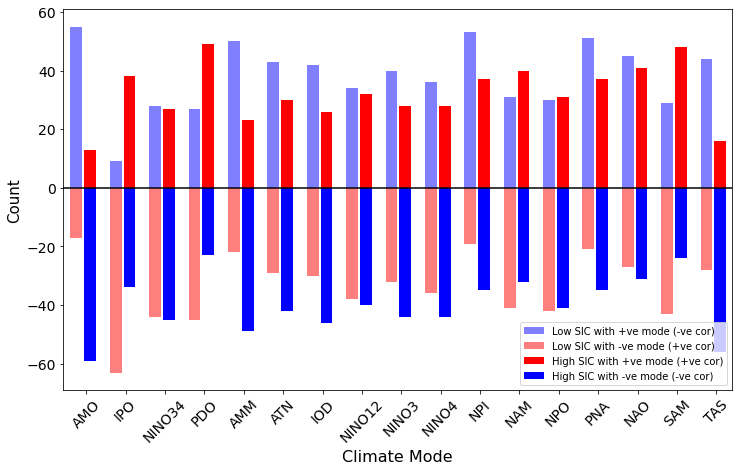

In [19]:
plt.figure(figsize=[12,7])
plt.bar(np.arange(-0.25,16), count_low_pos, color='b', label='Low SIC with +ve mode (-ve cor)', width=0.3, alpha=0.5)
plt.bar(np.arange(-0.25,16), np.array(count_low_neg)*-1, color='r', label='Low SIC with -ve mode (+ve cor)', width=0.3, alpha=0.5)

plt.bar(np.arange(0.1,17), count_high_pos, color='r', label='High SIC with +ve mode (+ve cor)', width=0.3)
plt.bar(np.arange(0.1,17), np.array(count_high_neg)*-1, color='b', label='High SIC with -ve mode (-ve cor)', width=0.3)

# plt.bar(CVDP_vars, np.array(count_high_pos)-np.array(count_high_neg), color='r', label='High SIC Anomaly',alpha=0.5)
plt.axhline(0, c='k')
plt.legend()

plt.xticks(np.arange(0,17), CVDP_vars);
plt.xlim(-0.6,16.4)
plt.yticks(fontsize=14);
plt.ylabel('Count',fontsize=15);
plt.xticks(fontsize=14, rotation=45);
plt.xlabel('Climate Mode', fontsize=16)

Text(0.5, 0, 'Climate Mode')

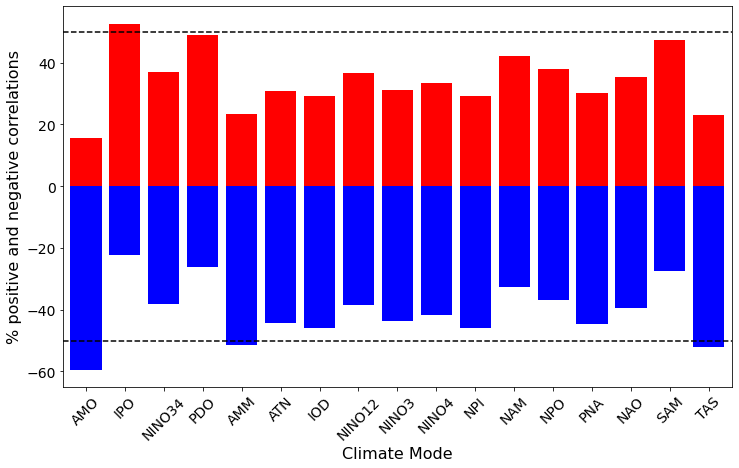

In [20]:
#+ve or -ve correlation
plt.figure(figsize=[12,7])
plt.bar(np.arange(1,18), (np.array(count_low_neg) + np.array(count_high_pos))/1.92, color='r')

plt.bar(np.arange(1,18), ((np.array(count_low_pos) + np.array(count_high_neg))*-1)/1.92, color='b')

plt.axhline(50, c='k', linestyle='--')
plt.axhline(-50, c='k', linestyle='--')

plt.xticks(np.arange(1,18), CVDP_vars);
plt.xlim(0.4,17.6);
plt.ylabel('% positive and negative correlations', fontsize=16)
plt.yticks(fontsize=14);
plt.xticks(fontsize=14, rotation=45);
plt.xlabel('Climate Mode', fontsize=16)



## Figure 7 - summary of net positive correlations

In [16]:
high_low_obs = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/predictions/'\
        f'HadISST1_binary_correlations_1956_2014_months_8_9_10_lag_1_20_'\
        'best_LE_seasons.nc'
    )
high_low_obs['region'] = [1,2,3,4,5,6,11]
high_low_obs['month'] = [8,9,10]

In [17]:
#load the correlation data for CMIP6
all_LE_high_low = {}
for GCM in GCM_LE_20:
    # high_low_LE = xr.open_dataset(
    #     f'/glade/work/cwpowell/low-frequency-variability/predictions/{GCM}_'\
    #     +'binary_correlations_1956_2014_months_8_9_10_lag_10_lowpass_filt.nc'
    # )
    high_low_LE = xr.open_dataset(
        f'/glade/work/cwpowell/low-frequency-variability/predictions/{GCM}_'\
            'binary_correlations_1956_2014_months_9_lag_4_15_best_LE_seasons_lowpass_filt.nc'
    )
    
    all_LE_high_low[GCM] = high_low_LE

In [101]:
with open('/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'\
          +'best_season_MMLE_3_lags_2_20_using_drop_1.pickle', 'rb') as handle:
    best_seasons_dict = pickle.load(handle)

In [18]:
CVDP_vars_list = [
        'AMO_1', 'IPO_4', 'NINO34_1', 'PDO_4', 'ATN_4', 'NPO_4', 'PNA_4',
        'NAO_1', 'TAS_7']#np.sort(list(best_seasons_dict['2'].keys()))

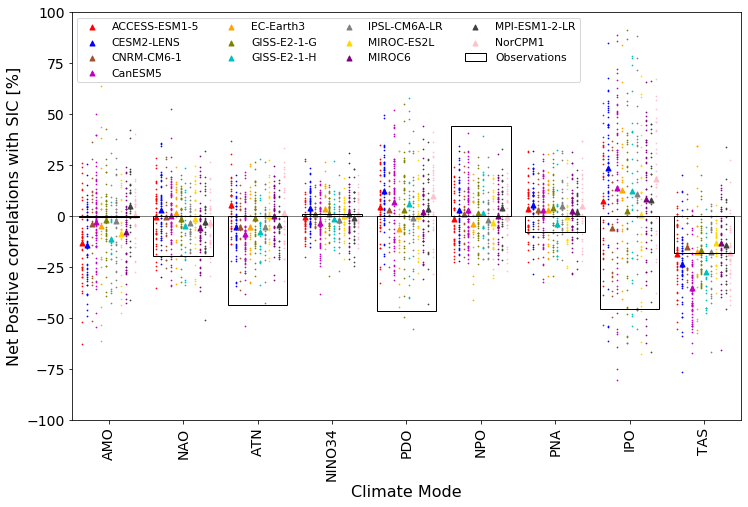

In [34]:
#use the best seasons based on the LE all region lag 4-15 September data
GCM_colors = ['r', 'b', 'sienna','m','orange','olive', 'c',
              '0.5','gold', 'purple','0.25','pink']

var_9_list = ['AMO', 'NAO', 'ATN', 'NINO34', 'PDO', 'NPO', 'PNA', 'IPO', 'TAS']
var_season = [    1,     1,    4,         1,      4,    4,     4,     4,     7]
fig = plt.figure(figsize=[12,7.5])

region_list = [1,2,3,4,5,11]
month_list = [9]
lag_list = np.arange(10,16)

for GCM_i, GCM in enumerate(GCM_LE_20):
    
    mem_ = len(CMIP6_mem[GCM])
    
    if GCM_i == 1:
        all_vars_obs = []
    for var_i, var_ in enumerate(var_9_list):    
        
        
        var_sel = var_+'_'+str(var_season[var_i])
            
        high_temp = all_LE_high_low[GCM]['high_SIC_anom'].sel(
            lag=lag_list).mean('lag').sel(month=month_list).mean('month').sel(
            region=region_list).mean('region').sel(var_month=var_sel)
        
        low_temp = all_LE_high_low[GCM]['low_SIC_anom'].sel(
            lag=lag_list).mean('lag').sel(month=month_list).mean('month').sel(
            region=region_list).mean('region').sel(var_month=var_sel)
        
        plt.scatter((np.ones(mem_)*var_i)+0.065*GCM_i-0.36, (high_temp-low_temp)\
                /(0.01*2*6), marker='.', s=2, color=GCM_colors[GCM_i])
        
        if var_i == 0: #make a label for the legend
            plt.scatter(var_i+(0.065*GCM_i)-0.36, 
                (high_temp.mean('member')-low_temp.mean('member'))\
                /(0.01*2*6), marker='^', s=25, label=GCM, 
                color=GCM_colors[GCM_i])
        else:
            plt.scatter(var_i+(0.065*GCM_i)-0.36, 
                (high_temp.mean('member')-low_temp.mean('member'))\
                /(0.01*2*6), marker='^', s=25, color=GCM_colors[GCM_i])
    
        if GCM_i == 11:
            high_temp_obs = high_low_obs['high_SIC_anom'].sel(lag=lag_list).mean(
                'lag').sel(month=month_list).mean('month').sel(region=region_list).mean(
                'region').sel(var_month=var_sel)
            low_temp_obs = high_low_obs['low_SIC_anom'].sel(lag=lag_list).mean(
                'lag').sel(month=month_list).mean('month').sel(region=region_list).mean(
                'region').sel(var_month=var_sel)
            all_vars_obs.append(high_temp_obs-low_temp_obs)
    
    
    #now plot the observations once
    if GCM_i == 11:
        plt.bar(var_9_list, (np.array(all_vars_obs)/(6*2*0.01)), 
                edgecolor='k', color='None', label='Observations')
    
        plt.xticks(var_9_list, labels=var_9_list, rotation=90, fontsize=14);
        plt.xlabel('Climate Mode', fontsize=16)
        plt.yticks(fontsize=14)

plt.axhline(0, c='k', linewidth=0.5)
leg = plt.legend(ncol=4, fontsize=10.8, loc='upper left')
    
plt.ylim(-100,100)
plt.xlim(-0.5,8.5)
plt.ylabel('Net Positive correlations with SIC [%]', fontsize=16);
fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/'\
    +f'Fig_7_Obs_LE_correlations_month_9_lags_10_15_not_Barents_var_9_best_season_LE.pdf',
    bbox_inches='tight')